In [1]:
import context

In [2]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [3]:
import os
import pickle
import numpy as np

In [4]:
from bestiary.criteria.autoencoder import AutoEncoderLoss

In [5]:
from bestiary.models import unsupervised

In [6]:
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, Checkpoint

In [7]:
import matplotlib.pyplot as plt

In [8]:
import torch
from torch import nn

In [9]:
from sklearn.datasets import fetch_openml

In [10]:
from skopt import BayesSearchCV

In [11]:
from scipy.stats import loguniform, randint

# Data

In [12]:
DATA_PATH = 'data/mnist.pkl'

if not os.path.exists(DATA_PATH):
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home='./data')
    X, y = X.astype(np.float32).reshape(-1, 28, 28), y.astype(np.int64).reshape(-1, 1)
    X = X / X.max()
    
    with open(DATA_PATH, 'wb') as f:
        pickle.dump((X, y), f)
else:
    with open(DATA_PATH, 'rb') as f:
        X, y = pickle.load(f)

In [13]:
X = X.reshape(-1, 784)

In [14]:
class Encoder(nn.Module):

    def __init__(self, latent_dim=10, dropout=.1):
        
        super(Encoder, self).__init__()
        
        self.net = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, latent_dim),
        )
        
    def forward(self, x):
        return self.net(x)

In [15]:
class Decoder(nn.Module):

    def __init__(self, latent_dim=10, dropout=.1):
        
        super(Decoder, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 784),
        )
        
    def forward(self, x):
        return torch.sigmoid(self.net(x))

In [16]:
class AutoEncoder(nn.Module):

    def __init__(self, latent_dim=10, dropout=.1):
        
        super(AutoEncoder, self).__init__()
        
        self.encoder = Encoder(latent_dim, dropout)
        self.decoder = Decoder(latent_dim, dropout)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded, encoded

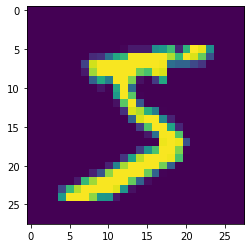

In [17]:
plt.imshow(X[0].reshape(28, 28))

# Vanilla

In [40]:
class AutoEncoderNet(NeuralNetRegressor):
    
    def encode(self, x):
        return self.module_.encoder(torch.tensor(x))
    
    
    def decode(self, x):
        return self.module_.decoder(torch.tensor(x))

In [42]:
vanilla = AutoEncoderNet(
    module=AutoEncoder,
    module__latent_dim=2,
    optimizer=torch.optim.Adam,
    criterion=AutoEncoderLoss,
    criterion__reconstruction_criterion=nn.MSELoss,
    max_epochs=10,
    lr=-1e-3,
    verbose=0,
    callbacks=[
        ('checkpoint', Checkpoint()),
        ('early_stopping', EarlyStopping(patience=3)),
    ]
)

In [28]:
params = dict(
    lr=loguniform(1e-5, 1e-2),
    module__dropout=loguniform(1e-2, .5),
)

cv = RandomizedSearchCV(vanilla, param_distributions=params, n_iter=5, cv=3, verbose=2, n_jobs=1)

In [43]:
vanilla.fit(X, X)

ValueError: Invalid learning rate: -0.001

In [39]:
vanilla.decode(vanilla.encode(X)).shape

<ipython-input-34-f282a5b12796>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.module_.decoder(torch.tensor(x))


torch.Size([70000, 784])

In [49]:
class L1Penalty(nn.Module):
    
    def __init__(self, ksi=1.):
        super(L1Penalty, self).__init__()
        self.ksi = ksi
        
    def forward(self, code):
        return torch.abs(code).mean()

In [50]:
sparse = NeuralNetRegressor(
    module=VariationalAutoEncoder,
    module__latent_dim=2,
    optimizer=torch.optim.Adam,
    criterion=AutoEncoderLoss,
    criterion__reconstruction_criterion=nn.MSELoss,
    criterion__code_criterion=L1Penalty,
    criterion__code_kwargs=dict(ksi=1e-3),
    max_epochs=30,
    lr=1e-4,
    callbacks=[
        Checkpoint(),
        EarlyStopping(patience=3),
    ]
)

In [129]:
class VariationalAutoEncoder(nn.Module):

    def __init__(self, latent_dim=10, dropout=.1):
        
        super(VariationalAutoEncoder, self).__init__()
        
        self.encoder = Encoder(latent_dim * 2, dropout)
        self.decoder = Decoder(latent_dim, dropout)
        
    def sample(self, mu, log_sigma):
        """
        Samples a vector within the latent space.

        Args:
            mu (torch.Tensor): The mean of the sampled tensor.
            log_sigma (torch.Tensor): The log-variance of the sampled tensor (log for stability reasons).

        Returns:
            z (torch.Tensor): The latent stochastic encoding.
        """

        sigma = torch.exp(.5 * log_sigma)
        epsilon = torch.randn_like(sigma)

        z = mu + sigma * epsilon

        return z
        
    def forward(self, x):
        encoded = self.encoder(x)
        
        code = torch.chunk(encoded, 2, dim=-1)
        
        sample = self.sample(*code)
        decoded = self.decoder(sample)
        
        return code, decoded

In [170]:
class KullbackLeiblerPenalty(nn.Module):
    
    def __init__(self, ksi=1.):
        super(KullbackLeiblerPenalty, self).__init__()
        self.ksi = ksi
        
    def forward(self, code):
        mu, log_sigma = code
        kl = -0.5 * (1 + log_sigma - mu.pow(2) - log_sigma.exp()).sum()
        return self.ksi * kl

In [182]:
vae = NeuralNetRegressor(
    module=VariationalAutoEncoder,
    module__latent_dim=2,
    optimizer=torch.optim.RMSprop,
    criterion=AutoEncoderLoss,
    criterion__reconstruction_criterion=nn.MSELoss,
    criterion__code_criterion=KullbackLeiblerPenalty,
    criterion__code_kwargs=dict(ksi=.1),
    max_epochs=30,
    lr=1e-3,
    callbacks=[
        Checkpoint(),
        EarlyStopping(patience=3),
    ]
)

In [184]:
vae.fit(X, X)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.0954        0.0683     +  3.5508
      2        0.0676        0.0681     +  3.4440
      3        0.0673        0.0681     +  3.4128
      4        0.0672        0.0680     +  3.4267
      5        0.0672        0.0680     +  3.4338
      6        0.0672        0.0680     +  3.5021
      7        0.0672        0.0680     +  3.6203
      8        0.0672        0.0680     +  3.6751
      9        0.0672        0.0679     +  3.7407
     10        0.0672        0.0679     +  3.7001
     11        0.0672        0.0679        3.5764
     12        0.0672        0.0679     +  3.7895
     13        0.0672        0.0679        4.0875
     14        0.0672        0.0679     +  4.0582
     15        0.0672        0.0679     +  4.3117
     16        0.0672        0.0679     +  4.4394
     17        0.0672        0.0679     +  4.4742
     18        0.0672        0.0679        4.8398


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=VariationalAutoEncoder(
    (encoder): Encoder(
      (net): Sequential(
        (0): Dropout(p=0.1, inplace=False)
        (1): Linear(in_features=784, out_features=128, bias=True)
        (2): ReLU()
        (3): Dropout(p=0.1, inplace=False)
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Dropout(p=0.1, inplace=False)
        (7): Linear(in_features=128, out_features=128, bias=True)
        (8): ReLU()
        (9): Dropout(p=0.1, inplace=False)
        (10): Linear(in_features=128, out_features=64, bias=True)
        (11): ReLU()
        (12): Dropout(p=0.1, inplace=False)
        (13): Linear(in_features=64, out_features=4, bias=True)
      )
    )
    (decoder): Decoder(
      (net): Sequential(
        (0): Linear(in_features=2, out_features=64, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=64, out_fea

In [31]:
vanilla.fit(X, X)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.0682        0.0552     +  3.6392
      2        0.0519        0.0489     +  3.6702
      3        0.0475        0.0454     +  3.8563


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=AutoEncoder(
    (encoder): Encoder(
      (net): Sequential(
        (0): Dropout(p=0.1, inplace=False)
        (1): Linear(in_features=784, out_features=128, bias=True)
        (2): ReLU()
        (3): Dropout(p=0.1, inplace=False)
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Dropout(p=0.1, inplace=False)
        (7): Linear(in_features=128, out_features=128, bias=True)
        (8): ReLU()
        (9): Dropout(p=0.1, inplace=False)
        (10): Linear(in_features=128, out_features=64, bias=True)
        (11): ReLU()
        (12): Dropout(p=0.1, inplace=False)
        (13): Linear(in_features=64, out_features=2, bias=True)
      )
    )
    (decoder): Decoder(
      (net): Sequential(
        (0): Linear(in_features=2, out_features=64, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=64, out_features=128, 

In [30]:
grid = np.stack([
    np.linspace(-1, 1, 21).reshape(-1, 1).repeat(21, axis=1),
    np.linspace(-1, 1, 21).reshape(1, -1).repeat(21, axis=0),
], axis=2)

In [31]:
grid = torch.tensor(grid.reshape(-1, 2), dtype=torch.float) * 1

In [33]:
reconstructed_grid = cv.module_.decoder(grid).detach().numpy()

AttributeError: 'RandomizedSearchCV' object has no attribute 'module_'

In [188]:
reconstructed_grid = reconstructed_grid.reshape(21, 21, 28, 28)

In [189]:
reconstructed_grid = np.concatenate([
    np.concatenate([rg__ for rg__ in rg_], axis=1)
    for rg_ in reconstructed_grid
], axis=0)

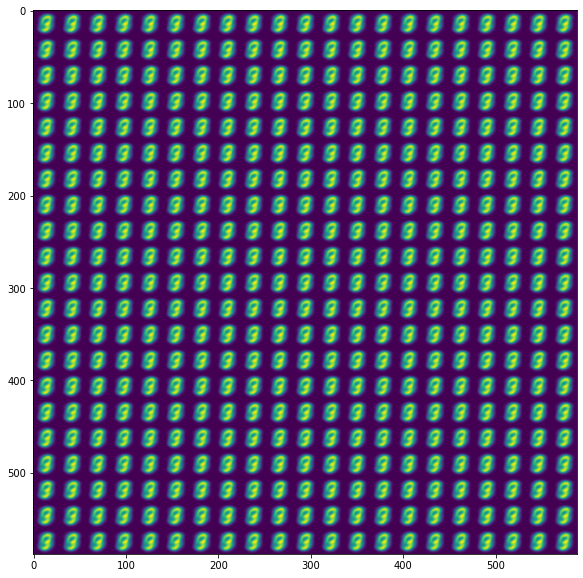

In [190]:
plt.figure(figsize=(10, 10))
plt.imshow(reconstructed_grid)

In [191]:
grid.shape

torch.Size([441, 2])

In [192]:
grid = grid.reshape(-1, 2)

In [194]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [196]:
code, reconstruction = vae.forward(X)

AttributeError: 'tuple' object has no attribute 'to'

In [177]:
reconstruction = torch.sigmoid(reconstruction)

In [94]:
i = 0

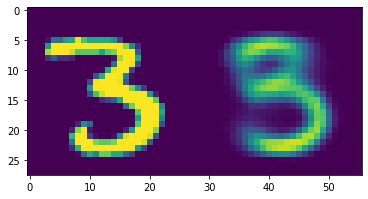

In [106]:
i += 1
plt.imshow(
    np.concatenate(
        [X[i].reshape(28, 28), reconstruction[i].reshape(28, 28)],
        axis=1,
    )
)

In [142]:
from sklearn.manifold import TSNE

In [143]:
tsne = TSNE()

In [153]:
subsample = np.random.choice(np.arange(len(y)), size=1000, replace=False)

In [162]:
transformed = tsne.fit_transform(code[subsample])

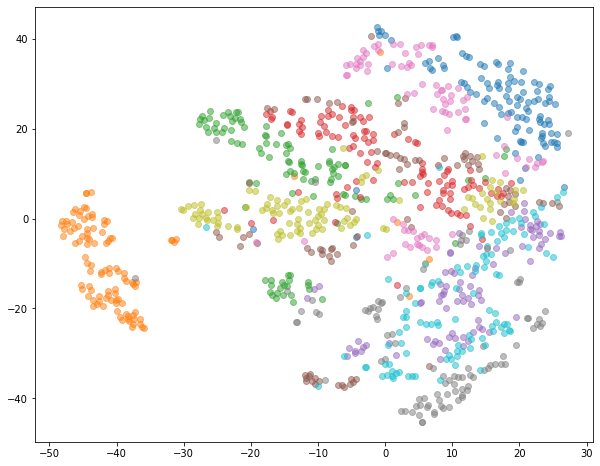

In [163]:
plt.figure(figsize=(10, 8))
for n in range(10):
    indices = y[subsample].reshape(-1) == n
    plt.scatter(*transformed[indices].T, color=f'C{n}', alpha=.5)

# Sparse